## Aplicando Random Forest a datos de gamma y protones

### 1. Juntar y leer los ficheros H5 con las imágenes

Importamos los módulos:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ctapipe.io import TableLoader

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

/tmp/ipykernel_15377/2141602193.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Cargamos las imágenes con TableLoader (permite leer los archivos H5):

In [2]:
with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=10000)
    
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=10000)

Determinamos los parámetros de las imágenes con los que vamos a trabajar y se lo determinamos a nuestras imágenes:

In [3]:
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 #'hillas_skewness',
 #'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]

# Mostramos el tipo de imágenes con las que el TableLoader nos ha devuelto los archivos h5
print(type(protons_tel_events_f)) 

<class 'astropy.table.table.Table'>


Convertimos a dataframe las imágenes para manjear datos con mayor facilidad: 

In [4]:
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()                                                              # Eliminamos filas con NaN values
df_protons = df_protons[(df_protons['hillas_intensity']<600)&(df_protons['hillas_length']<6)] # Eliminamos los eventos de muy alta y muy cortos
print(df_protons[0:5])
print(df_protons.shape)

   hillas_intensity  hillas_length  hillas_width  timing_slope
1        179.189536       0.075043      0.038707     -0.795857
2        175.102116       0.099796      0.037724     -0.183879
3        219.014162       0.067318      0.055117     -2.098332
4         76.100910       0.076310      0.053727      5.010075
5        114.284697       0.134224      0.067950      6.764235
(3409, 4)


In [5]:
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()                                                                  # Eliminamos filas con NaN values
df_gamma = df_gamma[df_gamma['hillas_intensity']<600]                                         # Eliminamos los eventos de muy alta intensidad
print(df_gamma[0:5])
print(df_gamma.shape)

   hillas_intensity  hillas_length  hillas_width  timing_slope
0         97.337978       0.108321      0.051531     -5.928553
2         54.234541       0.079777      0.050685    -10.780453
3        110.271869       0.196856      0.058297    -29.961223
4        216.849001       0.364693      0.062745    -29.131488
5         93.050237       0.097492      0.056339    -23.022860
(4119, 4)


Juntamos los dos dataframes en uno solo porque RandomForest necesita datos de los dos para funcionar. Además, ahora debemos añadir la etiqueta de los datos, si es protón o si es gamma para que el RandomForest pueda comprobar sus predicciones. Dado que del dataframe conjunto 3409 filas son de protones y 4119 filas son de gammas, añadiremos una nueva columna con las etiquetas:

In [6]:
df_protongamma = pd.concat([df_protons, df_gamma], axis=0)                                             # Une protones y gammas por filas
print(df_protongamma.shape)

label = []                                                                                             # Añade las etiquetas a los datos
for i in range(3409):
    label.append("proton")
for j in range(4119):
    label.append("gamma")

df_protongamma.insert(4,"label", label, True)
print(df_protongamma.shape)

(7528, 4)
(7528, 5)


In [7]:
print(df_protongamma[3405:3415])

      hillas_intensity  hillas_length  hillas_width  timing_slope   label
6284         88.391457       0.083337      0.038175      0.868545  proton
6287         97.145200       0.096007      0.045447     -2.104957  proton
6289         64.570495       0.082258      0.045599     -2.867887  proton
6290        117.966622       0.130640      0.050531      1.531302  proton
0            97.337978       0.108321      0.051531     -5.928553   gamma
2            54.234541       0.079777      0.050685    -10.780453   gamma
3           110.271869       0.196856      0.058297    -29.961223   gamma
4           216.849001       0.364693      0.062745    -29.131488   gamma
5            93.050237       0.097492      0.056339    -23.022860   gamma
6           271.092692       0.286222      0.077065    -23.332562   gamma


### 2. Entrenar el modelo

Ahora ya tenemos los datos preparados para realizar un primer RandomForest. Tenemos tanto las etiquetas de los datos como los parámetros que determinarán si es un protón o un gamma.

El siguiente paso es dividir los datos en datos para entrenar y en datos para comprobar que el RandomForest funciona:

In [11]:
X = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
y = df_protongamma["label"]                                                           # Determina las etiquetas 

# Dividimos los datos en dos, los que servirán para entrenar al RandomForest y los que servirán para comprobar que las predicciones son correctas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

print(X_train[0:5])
print()
print(y_train[0:5])
print()
print(X_test[0:5])
print()
print(y_test[0:5])

      hillas_intensity  hillas_length  hillas_width  timing_slope
4060         83.780974       0.072208      0.065532     -5.235353
386          94.366555       0.071739      0.060211      2.668664
1673         89.321432       0.071045      0.052556      2.579356
6058        154.519370       0.049597      0.031011     -0.976352
4835         75.834680       0.067897      0.044999      0.413494

4060     gamma
386      gamma
1673     gamma
6058    proton
4835     gamma
Name: label, dtype: object

      hillas_intensity  hillas_length  hillas_width  timing_slope
3701        505.137928       0.310426      0.085122      9.429493
6696        156.827621       0.070823      0.047730     -1.855634
1837         58.612759       0.072212      0.053404      3.906034
1780        368.966434       0.162616      0.052990      0.914191
5449         69.045493       0.084651      0.062408     10.551041

3701     gamma
6696     gamma
1837    proton
1780     gamma
5449     gamma
Name: label, dtype: object


Ahora solo queda entrenar el modelo y comprobar que es correcto:

In [12]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

Comprobamos los resultados obtenidos por el modelo usando los conjuntos de datos que habíamos separado para comprobar:

In [13]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

Precisión: 62.69449715370019 %


Visualicemos algunos de estos árboles:

In [44]:
# Crear figura y ejes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), dpi=200)

# Dibujar el árbol
tree.plot_tree(rf_model.estimators_[2],
               feature_names=X_train.columns, 
               max_depth=2,
               filled=True,
               impurity=True, 
               proportion=True,
               ax=axes,
               fontsize=10,  # Tamaño de fuente
               rounded=True,  # Bordes redondeados
               )

# Guardar la figura
fig.savefig('rf_individualtree.png', bbox_inches='tight')

In [31]:
from sklearn.tree import export_graphviz
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf_model.estimators_[0],
               feature_names=X_train.columns, 
               max_depth=3,
               filled=True,
               impurity=True, 
               proportion=True,
               ax=axes,
               fontsize=8,  # Tamaño de fuente
               node_size=500,  # Tamaño de los nodos
               rounded=True,  # Bordes redondeados
               )
fig.savefig('rf_individualtree.png')

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf_model.estimators_[0],
               feature_names = X_train.columns, 
               max_depth=3,
               filled = True,
               impurity=True, 
               proportion=True);
fig.savefig('rf_individualtree.png')

fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf_model.estimators_[index],
                   feature_names = X_train.columns,
                   max_depth=2,
                   filled = True,
                    impurity=True, 
                   proportion=True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

Este primer RandomForest es una primera aproximación, con una precisión de alrededor del 62,5 %. Sin embargo, podemos mejorar estos resultados. 

### 3. Mejorar el modelo

Para mejorar el modelo deberemos empezar por optimizar los hiperparámetros del RandomForest y así, mediante la determinación óptima del número de árboles de decisión, del número de decisiones por árbol y otros hiperparámetros se podrá mejorar el modelo.

In [12]:
# Definimos los parámetros que vamos a optimizar y entre que valores creemos que se encontrará el valor óptimo
param_dist = {'n_estimators': randint(350,450), 'max_depth': randint(4,10)}

# Creamos un nuevo RandomForest
rf = RandomForestClassifier()

# Usamos parámetros aleatorios entre los valores que hemos determinado y entrenamos varios RF (10). 
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=10, cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Guarda cada modelo como una variable y del que obtiene mejores resultados devuelve sus parámetros optimizados
best_rf = rand_search.best_estimator_
print('Mejores parámetros:',  rand_search.best_params_)

Mejores parámetros: {'max_depth': 7, 'n_estimators': 424}


Probamos los nuevos hiperparámetros para ver la mejora del RandomForest:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rf_best = RandomForestClassifier(n_estimators = 400, max_depth= 9)
rf_best.fit(X_train, y_train)

y_pred = rf_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

Precisión: 64.9402390438247 %


No ha mejorado mucho la verdad pero por algo se empieza.

Sometemos este nuevo modelo a varias evaluaciones más para estuidar mejor su comportamiento:

##### 3.1 Matriz de confusión

Precisión: 63.47941567065073 %
[[328  75]
 [200 150]]


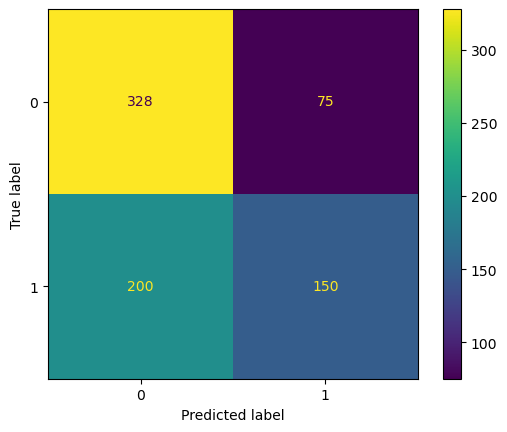

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
rf_best = RandomForestClassifier(n_estimators = 400, max_depth= 9)
rf_best.fit(X_train, y_train)

# Utlilizamos el mejor modelo para realizar predicciones
y_pred = rf_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy*100, "%" )

# Creamos la matriz de confusión para evaluar sus resultados
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(confusion_matrix(y_test, y_pred))

Donde 0 indica que es un gamma y 1 indica que es un protón. Podemos ver claramente que el RF predice bastante bien (80 %) cuando es un rayo gamma pero no tan bien (50 %) cuando es un protón.

Esto puede deberse a varios motivos:
1. La menor cantidad de datos de protones con respecto a gammas de los archivos usados para entrenar el modelo
1. La mayor dispersión de los datos de protones lo que provoca que el modelo no asigne correctamente los parámetros que determinan a los protones

#### 3.2 Peso de los parámetros

Vamos ahora a ver cuáles son los parámetros que tienen más peso a la hora de tomar la decisión:

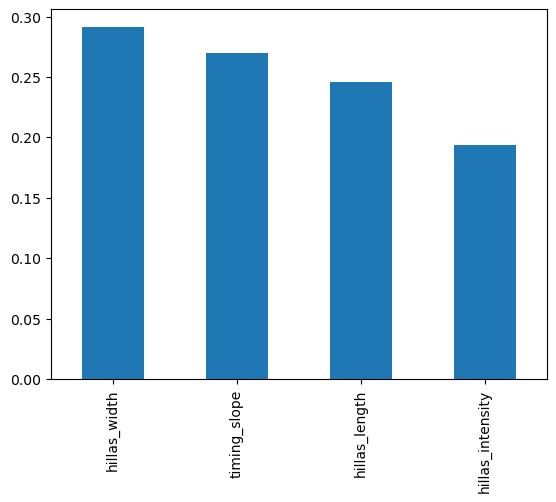

In [15]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Mostramos la importancia de cada parámetro
feature_importances.plot.bar();

A partir de aquí, quizás otra manera de mejorar el modelo es introduciendo más parámetros y ver cuáles de ellos tienen más peso a la hora de tomar la decisión para el mejor RF.